<a href="https://colab.research.google.com/github/Nhathuyy/NLP-Ensembling/blob/main/Disaster_Tweet_Classification_with_NLP_Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<div style="color:;
           display:fill;
           border-radius:5px;
           background-color: lightgray;
           font-size:110%;
           letter-spacing:0.5px">

<h2 style="padding: 10px;
              color:white;">Disaster Tweets
</h2>
</div>

1. [Introduction](#introduction)
1. [Data Collection](#datacollection)
1. [Data Analysis](#dataanalysis)
    1. [Explore Dataset](#exploredataset)
    1. [Explore Target Variable](#exploretargetvariable)
    1. [EDA Summary](#edasummary)
1. [Data Preprocessing](#datapreprocessing)

1. [Model Training and Evaluation](#trainandevaluate)
    1. [Simple RNN](#simplernn)
    1. [Universal Sentence Encoder](#use)
    1. [RoBERTa](#roberta)
    1. [Twitter-RoBERTa](#twitterroberta)
    1. [Bert](#bert)
    1. [Distilbert](#distilbert)
    1. [Ensembling](#ensembling)
1. [Submission](#submission)
1. [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>

In this notebook, I am going to evaluate different techiques for text analysis, data cleaning and so on. For this classification task I will assess several neural network models: pre-trained from <a href="ttps://huggingface.co/">HuggingFace</a> and a simple RNN model built from scratch.

This notebook covers:
1. Exploratory Data Analysis
1. Cleaning and text processing
1. Sentence encoding using tokenization and embeddings
1. Training and evaluation of some BERT family models and a simple RNN model
1. Stacking the best results

In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import time
import os
import numpy as np
import pandas as pd
import math
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import tensorflow_hub as hub
from PIL import Image
import itertools
from itertools import islice
from scipy.special import softmax
import tensorflow as tf
import keras_tuner as kt
import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, concatenate, Average, Concatenate, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.utils import to_categorical, plot_model
from keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from keras.metrics import categorical_accuracy
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, make_scorer,roc_curve, precision_recall_curve
from matplotlib.colors import ListedColormap
import seaborn as sns

from transformers import TFRobertaForSequenceClassification, TFAutoModelForSequenceClassification, RobertaTokenizer, AutoTokenizer, DistilBertTokenizer, TFDistilBertForSequenceClassification

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")

# Data Collection <a class="anchor" id="datacollection"></a>

In [ ]:
competition = "nlp-getting-started"
if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
    submission_path = "sample_submission.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    submission_path = f"/kaggle/input/{competition}/sample_submission.csv"

train_df = pd.read_csv(train_path, index_col='id')
test_df = pd.read_csv(test_path, index_col='id')
submission_df = pd.read_csv(submission_path, index_col='id')

NameError: ignored

In [ ]:
import pandas as pd

# Xác định biến cạnh tranh (competition) và ON_KAGGLE
competition = "nlp-getting-started"
ON_KAGGLE = False  # Đặt thành True nếu bạn đang chạy trên Kaggle

# Kiểm tra nếu bạn không chạy trên Kaggle
if not ON_KAGGLE:
    # Thay đổi đường dẫn của tệp CSV tại đây nếu cần thiết
    train_csv_url = "https://raw.githubusercontent.com/Nhathuyy/Colab/main/train.csv"
    test_csv_url = "https://raw.githubusercontent.com/Nhathuyy/Colab/main/test.csv"
    sample_submission_csv_url = "https://raw.githubusercontent.com/Nhathuyy/Colab/main/sample_submission.csv"

    # Đọc dữ liệu từ các URL trực tiếp
    train_df = pd.read_csv(train_csv_url, index_col='id')
    test_df = pd.read_csv(test_csv_url, index_col='id')
    submission_df = pd.read_csv(sample_submission_csv_url, index_col='id')
else:
    # Xác định đường dẫn tệp CSV trên Kaggle
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    submission_path = f"/kaggle/input/{competition}/sample_submission.csv"

    # Đọc dữ liệu từ tệp CSV trên Kaggle
    train_df = pd.read_csv(train_path, index_col='id')
    test_df = pd.read_csv(test_path, index_col='id')
    submission_df = pd.read_csv(submission_path, index_col='id')

print('Training Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))
print('sample_submission Set Shape = {}'.format(submission_df.shape))


Training Set Shape = (7613, 4)
Test Set Shape = (3263, 3)
sample_submission Set Shape = (3263, 1)


# Data Analysis <a class="anchor" id="dataanalysis"></a>

## Explore Dataset <a class="anchor" id="exploredataset"></a>

Explore basic information about the dataset.

In [ ]:
print(f'Train dataset shape:\t {train_df.shape}',
    f'\nTest dataset shape:\t {test_df.shape}')

Train dataset shape:	 (7613, 4) 
Test dataset shape:	 (3263, 3)


In [ ]:
train_df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [ ]:
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [ ]:
print('Train dataset, missing values:', train_df.isna().sum().sum())
print('Test dataset, missing values:', test_df.isna().sum().sum())

Train dataset, missing values: 2594
Test dataset, missing values: 1131


Check keywords and location values.

In [ ]:
train_df["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
train_df["location"].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

### Check duplicates

Check the training set for duplicates that are mislabeled. Prior to training, target values should be relabeled as they may affect the training score.

In [ ]:
duplicates = train_df.duplicated(subset=['text'], keep=False)
duplicates_mislabeled = (train_df[duplicates]
                         .groupby(['text'])
                         .filter(lambda x: len(x['target'].unique()) > 1)
                         .sort_values(by='text'))
duplicates_mislabeled.head()

,keyword,location,text,target
id,,,,
6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into ...,0
5996,hazardous,NaN,#foodscare #offers2go #NestleIndia slips into ...,1


In [ ]:
duplicates_mislabeled.shape

(55, 4)

In [ ]:
for i,row in duplicates_mislabeled.sort_values('text').iterrows():
    print(i, row['target'], row['text'])

6094 0 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
6105 0 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
6123 1 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
6031 0 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption
5996 1 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption
6023 1 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption
4076 0 .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4
4072 1 .POTUS #StrategicPatience is a strateg

In [ ]:
relabel_ids_to_1 = [4076, 4072, 4068, 4077, 6566, 6548, 6537, 6017, 6012, 5699, 5662, 5710]
relabel_ids_to_0 = [881, 898, 907, 916, 1723, 1922, 1752, 1968, 6094, 6105, 6123, 6031, 5996, 6023, 4684, 4656, 4659, 4669, 4672, 4691, 6088, 6125, 6112, 6134, 6113, 9472, 9470, 6223, 6220, 6087, 6132, 6090, 6097, 6118, 6111, 1760, 1950, 8698, 8702, 8714, 8739, 8018, 8044]

### Strings length

Explore the length of tweets.

In [ ]:
tweets_chars_len = train_df['text'].str.len()
tweets_chars_len

id
1         69
4         38
5        133
6         65
7         88
        ... 
10869     83
10870    125
10871     65
10872    137
10873     94
Name: text, Length: 7613, dtype: int64

In [ ]:
tweets_chars_len.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

Check tweets with max and min length.

In [ ]:
max_chars_len_index = tweets_chars_len.argmax()
min_chars_len_index = tweets_chars_len.argmin()

In [ ]:
train_df.iloc[max_chars_len_index][['keyword', 'location', 'target']], train_df.iloc[max_chars_len_index]['text']

(keyword     burned
 location       NaN
 target           0
 Name: 1832, dtype: object,
 "when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????")

In [ ]:
train_df.iloc[min_chars_len_index][['keyword', 'location', 'target']], train_df.iloc[min_chars_len_index]['text']

(keyword     crushed
 location        NaN
 target            0
 Name: 2703, dtype: object,
 'Crushed')

### Strings content

Check how many tweets contain URLs.

In [ ]:
train_df.query('text.str.contains("http://")')

,keyword,location,text,target
id,,,,
48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
...,...,...,...,...
10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [ ]:
train_df.loc[48, 'text']

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [ ]:
train_df[train_df['target'] == 0]

,keyword,location,text,target
id,,,,
23,NaN,NaN,What's up man?,0
24,NaN,NaN,I love fruits,0
25,NaN,NaN,Summer is lovely,0
26,NaN,NaN,My car is so fast,0
28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...
10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0


In [ ]:
train_df[train_df['target'] == 1]

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


### Vocabulary analysys

The TextVectorization layer explores the basic vocabulary of the dataset. For other tokenizers, of course, this information may be different.

In [ ]:
text_vec_layer_eda = tf.keras.layers.TextVectorization(
    standardize="lower", ragged=True)
text_vec_layer_eda.adapt(train_df['text'])
vocab_size_eda = text_vec_layer_eda.vocabulary_size()
print(f"Vocabulary size: {vocab_size_eda}")

Vocabulary size: 27985


In [ ]:
vocab_eda = text_vec_layer_eda.get_vocabulary()
vocab_eda_np = np.array(vocab_eda)
vocab_eda_np

array(['', '[UNK]', 'the', ..., '!!!!!!!!!!!#metrofmtalk', '!!!!!',
       '!!!!'], dtype='<U62')

In [ ]:
vocab_urls = vocab_eda_np[np.char.find(vocab_eda_np, 'http') >= 0]
print(vocab_urls)
print("Unique urls count in vocab:", len(vocab_urls))

['http://t.co/qew4c5m1xd' 'http://t.co/q2eblokeve'
 'http://t.co/ksawlyux02' ... '(http://t.co/ed1vpitswy):'
 '(http://t.co/18xq3fmuge)' "'quantit\x89Û_https://t.co/64cymg1ltg"]
Unique urls count in vocab: 4599


Get tokenized data.

In [ ]:
tweets_tokenized = text_vec_layer_eda(train_df['text'])

Get the number of tokens in each tweet and plot their frequency.

In [ ]:
tweets_tokens_counts = tweets_tokenized.row_lengths().numpy()
tweets_tokens_counts[:14]

array([13,  7, 22,  8, 16, 18, 14, 15, 12, 10,  9, 27, 12,  7])

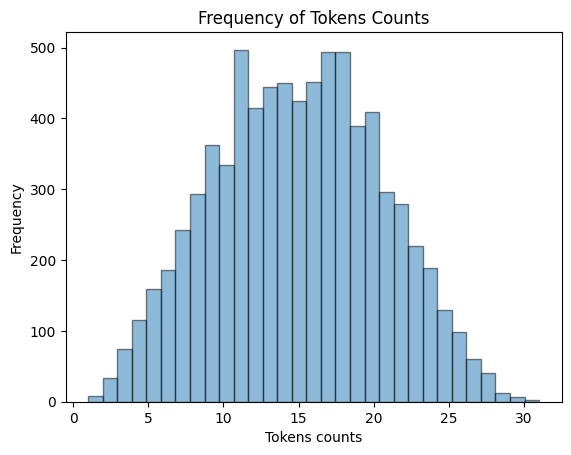

In [ ]:
plt.hist(tweets_tokens_counts, bins=31, alpha=0.5, ec='black')
plt.xlabel('Tokens counts')
plt.ylabel('Frequency')
plt.title('Frequency of Tokens Counts')
plt.show()

Check tweets for maximum word count.

In [ ]:
max_tokens_count = tweets_tokenized.bounding_shape().numpy()[1]
print(f"Max words count: {max_tokens_count}")

Max words count: 31


In [ ]:
tweets_max_tokens = np.where(tweets_tokens_counts == max_tokens_count)[0]
tweets_max_tokens

array([ 954, 4432, 5005])

In [ ]:
tweet_max_tokens = train_df.iloc[tweets_max_tokens[-1]]
tweet_max_tokens[['keyword', 'location', 'target']], tweet_max_tokens['text']

(keyword     military
 location         NaN
 target             0
 Name: 7138, dtype: object,
 'I remember when I worked at Mcdonalds I use to be hours late because we used military time and I use to mess up when I had to be there :/')

See how the TextVectorization layer works. Convert sample tweet to tokens and vice versa.

In [ ]:
tweet_max_tokens_ids = text_vec_layer_eda(tweet_max_tokens['text'])
tweet_max_tokens_ids

<tf.Tensor: shape=(31,), dtype=int64, numpy=
array([   8,  525,   43,    8, 2045,   17, 5771,    8,  491,    5,   23,
        653, 1435,  146,   47,  468,  254,  105,    7,    8,  491,    5,
       2536,   32,   43,    8,   90,    5,   23,   75, 4603])>

In [ ]:
[text_vec_layer_eda.get_vocabulary()[i] for i in tweet_max_tokens_ids]

['i',
 'remember',
 'when',
 'i',
 'worked',
 'at',
 'mcdonalds',
 'i',
 'use',
 'to',
 'be',
 'hours',
 'late',
 'because',
 'we',
 'used',
 'military',
 'time',
 'and',
 'i',
 'use',
 'to',
 'mess',
 'up',
 'when',
 'i',
 'had',
 'to',
 'be',
 'there',
 ':/']

## Explore Target Variable <a class="anchor" id="exploretargetvariable"></a>

In [ ]:
labels = train_df['target']
labels.unique()

array([1, 0])

In [ ]:
if labels.isnull().sum()==0:
    print("No missing values")
else:
    print(label.isnull().sum(), 'missing values found in dataset')

No missing values


In [ ]:
def plot_label(label):
    fig = px.pie(label.value_counts(), names=label.map({1:'Disaster (1)', 0:'No disaster (0)'}),
        color_discrete_sequence=['green', 'red'], width=500, height=500)
    fig.update_traces(textinfo='percent+value')
    fig.show()

In [ ]:
plot_label(labels)

## EDA Summary <a class="anchor" id="edasummary"></a>

1. Training dataset has 7613 items with 3 features and 1 target label in column 'target'
1. Test dataset has 3263 items with the same 3 features as training set. It doesn't have a 'target' column.
1. There are 3 object/text features: 'keyword', 'location', 'text'
1. Target is binary categorical.
1. The following features have missing values: 'keyword', 'location'
1. There are 18 duplicate and mislabeled items.

Strategy for the feature ingineering:
1. 'keyword', 'location' - leave as is.; these features do not seem to be that useful, so they can be dropped for neural network models.
1. 'text' - remove (or replace) substrings like urls (starting with http), twitters accounts (starting with @).
1. 'target' - relabel duplicate and mislabeled items.

# Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

### Replace substrings

In [ ]:
def replace_substrings(df):
    replacements = {
        '@\w+': '@user',
        'https?\S+': 'http',
    }
    df["text_new"] = df["text"].replace(replacements, regex=True)
    return df

In [ ]:
train_df = replace_substrings(train_df)
train_df[30:35]

,keyword,location,text,target,text_new
id,,,,,
44,NaN,NaN,The end!,0,The end!
48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@user Wholesale Markets ablaze http
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,We always try to bring the heavy. #metal #RT http
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#AFRICANBAZE: Breaking news:Nigeria flag set a...
52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze


In [ ]:
test_df = replace_substrings(test_df)
test_df[20:25]

,keyword,location,text,text_new
id,,,,
69,ablaze,threeonefive.,beware world ablaze sierra leone &amp; guap.,beware world ablaze sierra leone &amp; guap.
70,ablaze,Washington State,Burning Man Ablaze! by Turban Diva http://t.co...,Burning Man Ablaze! by Turban Diva http via @user
72,ablaze,"Whoop Ass, Georgia",Not a diss song. People will take 1 thing and ...,Not a diss song. People will take 1 thing and ...
75,ablaze,India,Rape victim dies as she sets herself ablaze: A...,Rape victim dies as she sets herself ablaze: A...
84,ablaze,NaN,SETTING MYSELF ABLAZE http://t.co/6vMe7P5XhC,SETTING MYSELF ABLAZE http


### Relabel

Relabel mislabeled duplicates.

In [ ]:
train_df['target_relabeled'] = train_df['target'].copy()

In [ ]:
train_df.loc[relabel_ids_to_0, ['target_relabeled']] = 0
train_df.loc[relabel_ids_to_0].head()

,keyword,location,text,target,text_new,target_relabeled
id,,,,,,
881,bioterrorism,NaN,To fight bioterrorism sir.,1,To fight bioterrorism sir.,0
898,bioterrorism,NaN,To fight bioterrorism sir.,0,To fight bioterrorism sir.,0
907,bioterrorism,NaN,To fight bioterrorism sir.,1,To fight bioterrorism sir.,0
916,bioterrorism,NaN,To fight bioterrorism sir.,0,To fight bioterrorism sir.,0
1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1,Mmmmmm I'm burning.... I'm burning buildings I...,0


In [ ]:
train_df.loc[relabel_ids_to_1, ['target_relabeled']] = 1
train_df.loc[relabel_ids_to_1].head()

,keyword,location,text,target,text_new,target_relabeled
id,,,,,,
4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0,.POTUS #StrategicPatience is a strategy for #G...,1
4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1,.POTUS #StrategicPatience is a strategy for #G...,1
4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1,.POTUS #StrategicPatience is a strategy for #G...,1
4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1,.POTUS #StrategicPatience is a strategy for #G...,1
6566,injury,NaN,CLEARED:incident with injury:I-495 inner loop...,0,CLEARED:incident with injury:I-495 inner loop...,1


### Splitting data

In [ ]:
X_full = train_df['text_new'].to_numpy()
y_full = train_df['target_relabeled'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.15, stratify = y_full)
X_full.shape, y_full.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7613,), (7613,), (6471,), (6471,), (1142,), (1142,))

In [ ]:
X_test = test_df['text_new'].to_numpy()
X_test.shape

(3263,)

### Create Dataset

In [ ]:
train_ds_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds_raw = tf.data.Dataset.from_tensor_slices(X_test)
train_ds_raw.element_spec, val_ds_raw.element_spec, test_ds_raw.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 TensorSpec(shape=(), dtype=tf.string, name=None))

# Model Training and Evaluation <a class="anchor" id="trainandevaluate"></a>

In [ ]:
!pip install scikit-plot


In [ ]:
import scikitplot as skplt

class EstimatorReport():
    """
    A class used for generating a report on an estimator's performance

    Attributes
    ----------
    X_val : np.ndarray
        Validation dataset features.
    y_val : np.ndarray
        Validation dataset labels.
    X_train : np.ndarray
        Training dataset features.
    y_train : np.ndarray
        Training dataset labels.
    estimator : estimator object
        Scikit-learn estimator object.
    estimator_name : str
        Name of the estimator.
    plot_micro : bool
        Whether micro average ROC curve should be plotted.
    plot_macro : bool
        Whether macro average ROC curve should be plotted.
    metrics_calculated : bool
        Whether the performance metrics have been calculated.

    Methods
    -------
    calculate_metrics()
        Calculates accuracy, confusion matrix, classification report and predicted probabilities
        based on the validation set and sets metrics_calculated flag to True.
    plot_curves(figsize=(18, 4))
        Plots ROC and PR curves and learning curve based on the validation set.
    display_report(figsize=(10, 5))
        Displays a report on estimator's performance based on validation set.
    __plot_confusion_matrix(ax)
        Plots confusion matrix.
    __plot_classification_report(ax)
        Plots classification report.
    """
    def __init__(
        self,
        estimator,
        X_val: np.ndarray,
        y_val: np.ndarray,
        X_train: np.ndarray,
        y_train: np.ndarray,
        estimator_name: str,
        argmax = False,
        classes_count = None,
        binary_probas = False
    ) -> None:
        self.X_val = X_val
        self.y_val = y_val
        self.X_train = X_train
        self.y_train = y_train
        self.estimator = estimator
        self.estimator_name = estimator_name
        self.plot_micro = False
        self.plot_macro = False
        self.metrics_calculated = False
        self.argmax = argmax
        self.classes_count = classes_count
        self.binary_probas = binary_probas

    def calculate_metrics(self) -> None:
        self.y_val_predicted = self.estimator.predict(self.X_val)
        if self.argmax:
            self.y_val_probas = self.estimator.predict(self.X_val)
            try:
                self.y_val_predicted = self.y_val_probas.argmax(axis=-1)
            except:
                self.y_val_predicted = np.argmax(self.y_val_probas.logits, axis=1)
        else:
            self.y_val_predicted = self.estimator.predict(self.X_val)
            try:
                self.y_val_probas = self.estimator.predict_proba(self.X_val)
            except:
                try:
                    self.y_val_probas = self.estimator.decision_function(self.X_val)
                except:
                    self.y_val_probas = self.y_val_predicted.copy()
        if self.binary_probas:
            self.y_val_predicted = [1 if each > 0.5 else 0 for each in self.y_val_predicted]
        self.accuracy = accuracy_score(self.y_val, self.y_val_predicted)
        self.conf_mx = confusion_matrix(self.y_val, self.y_val_predicted)
        self.classif_report = classification_report(
            self.y_val, self.y_val_predicted, output_dict=True
        )
        self.metrics_calculated = True

    def plot_curves(self, figsize=(18, 4)) -> None:
        if not self.metrics_calculated:
            self.calculate_metrics()
        fig, axes = plt.subplots(
            1, 3, figsize=figsize, sharex=False,
            gridspec_kw={'width_ratios': [1, 1, 1]}, dpi=100
        )
        skplt.metrics.plot_roc(
            y_true=self.y_val, y_probas=self.y_val_probas, ax=axes[0],
            title='ROC curve', plot_micro=self.plot_micro, plot_macro=self.plot_macro
        )
        skplt.metrics.plot_precision_recall(
            y_true=self.y_val, y_probas=self.y_val_probas, ax=axes[1],
            title='PR curve', plot_micro=self.plot_micro
        )
        skplt.estimators.plot_learning_curve(
            self.estimator, self.X_train, self.y_train, ax=axes[2]
        )
        axes[0].grid()
        axes[1].grid()

    def display_report(self, figsize=(10, 5)) -> None:
        if not self.metrics_calculated:
            self.calculate_metrics()
        display(Markdown(f'### <span style="color: black;">Evaluation on the Validation Set (estimator: {self.estimator_name})</span>'))
        display(Markdown('Accuracy: {:.4f}%'.format(self.accuracy*100)))
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize, sharex=False,
                                   gridspec_kw={'width_ratios': [1, 2.2]}, dpi=100)
        self.__plot_classification_report(ax0)
        self.__plot_confusion_matrix(ax1)
        fig.tight_layout()
        plt.show()

    def __plot_confusion_matrix(self, ax) -> None:
        norm_conf_mx = self.conf_mx.astype('float') / self.conf_mx.sum(axis=1, keepdims=True)
        np.fill_diagonal(norm_conf_mx, 0)
        sns.heatmap(
            norm_conf_mx, ax=ax,
            annot=False, cmap=plt.cm.gray, cbar=False
        )
        plt.title('Confusion matrix')
        thresh = norm_conf_mx.max() / 2
        for i, j in itertools.product(range(self.conf_mx.shape[0]), range(self.conf_mx.shape[1])):
            plt.text(j+0.5, i+0.6, self.conf_mx[i, j],
                ha="center",
                va='baseline',
                color="white" if norm_conf_mx[i, j] < thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    def __plot_classification_report(self, ax) -> None:
        clf_report_df = pd.DataFrame(self.classif_report ).iloc[:-1, :].T
        classes_count = self.classes_count if (self.classes_count != None) else len(self.estimator.classes_)
        mask_classes = np.zeros_like(clf_report_df, dtype=bool)
        mask_classes[classes_count:, :] = True
        mask_metrics = np.zeros_like(clf_report_df, dtype=bool)
        mask_metrics[:classes_count, :] = True
        cmap_white = ListedColormap(['white'])
        sns.heatmap(
            clf_report_df, ax=ax, mask=mask_classes,
            annot=True, cmap='viridis', fmt='.6f', cbar=False
        )
        sns.heatmap(
            clf_report_df, ax=ax, mask=mask_metrics,
            annot=True, cmap=cmap_white, fmt='.6f', cbar=False
        )
        ax.set_title("Classification report", fontsize=10, pad=10)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [ ]:
def fit_and_evaluate(model, train_ds, val_ds, learning_rate=0.001,
                     epochs=50, loss="binary_crossentropy", es_patience=10):
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
        patience=2, monitor="val_accuracy", factor=0.3, verbose=1)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=es_patience, restore_best_weights=True)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping_cb, reduce_lr_cb])
    result = model.evaluate(val_ds)
    return result

In [ ]:
def add_to_results(model_name, acc, results_df):
    row = {
        'model': model_name,
        'accuracy': acc
    }
    if model_name in results_df['model'].values:
        row_index = results_df.loc[results_df['model'] == model_name].index[0]
        results_df.loc[row_index, 'accuracy'] = row['accuracy']
    else:
        results_df = results_df.append(row, ignore_index=True)
    return results_df

In [ ]:
results_df = pd.DataFrame(columns=['model', 'accuracy'])

## Simple RNN (GRU) <a class="anchor" id="simplernn"></a>

First create and assess simple RNN model using GRU (Gated Recurrent Unit) layer. As we saw in EDA training data vocabulary contains about 30'000 words. A lot of these words are not useful, so just cut vocabulary to smaller size.

In [ ]:
vocab_size = 16000
max_length = 31
text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize="lower",
    ragged=True
)
text_vec_layer.adapt(X_full)
vocab_size = text_vec_layer.vocabulary_size()

In [ ]:
embed_size = 128
model_rnn_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 128)         2048000   
                                                                 
 gru (GRU)                   (None, 16)                7008      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2055025 (7.84 MB)
Trainable params: 2055025 (7.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_ds = train_ds_raw.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.batch(32)

In [ ]:
%%time
_, acc = fit_and_evaluate(model_rnn_1, train_ds, val_ds)

Epoch 1/50
203/203 [==============================] - 64s 223ms/step - loss: 0.5704 - accuracy: 0.7042 - val_loss: 0.4539 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 2/50
203/203 [==============================] - 2s 12ms/step - loss: 0.2895 - accuracy: 0.8846 - val_loss: 0.5494 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 3/50
197/203 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9484
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
203/203 [==============================] - 2s 8ms/step - loss: 0.1500 - accuracy: 0.9482 - val_loss: 0.6551 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 4/50
203/203 [==============================] - 2s 8ms/step - loss: 0.0715 - accuracy: 0.9794 - val_loss: 0.6910 - val_accuracy: 0.7697 - lr: 3.0000e-04
Epoch 5/50
197/203 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9818
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
203/203 [==============================

In [ ]:
import matplotlib.pyplot as plt

# Import thư viện để tính thời gian
import time

# Định nghĩa hàm huấn luyện và đánh giá mô hình
def fit_and_evaluate(model, train_dataset, val_dataset):
    start_time = time.time()

    history = model.fit(train_dataset,
                        epochs=NUM_EPOCHS,
                        validation_data=val_dataset,
                        verbose=1)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # In biểu đồ loss và accuracy
    plt.figure(figsize=(12, 4))

    # Biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm fit_and_evaluate và hiển thị biểu đồ
fit_and_evaluate(model_rnn_1, train_ds, val_ds)


In [ ]:
import matplotlib.pyplot as plt

# Import thư viện để tính thời gian
import time

# Định nghĩa hàm huấn luyện và đánh giá mô hình
def fit_and_evaluate(model, train_dataset, val_dataset):
    start_time = time.time()

    history = model.fit(train_dataset,
                        epochs=NUM_EPOCHS,
                        validation_data=val_dataset,
                        verbose=1)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # In biểu đồ loss và accuracy
    plt.figure(figsize=(12, 4))

    # Biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm fit_and_evaluate và hiển thị biểu đồ
fit_and_evaluate(model_rnn_1, train_ds, val_ds)


36/36 [==============================] - 0s 4ms/step


### <span style="color: black;">Evaluation on the Validation Set (estimator: RNN-GRU)</span>

Accuracy: 80.2102%

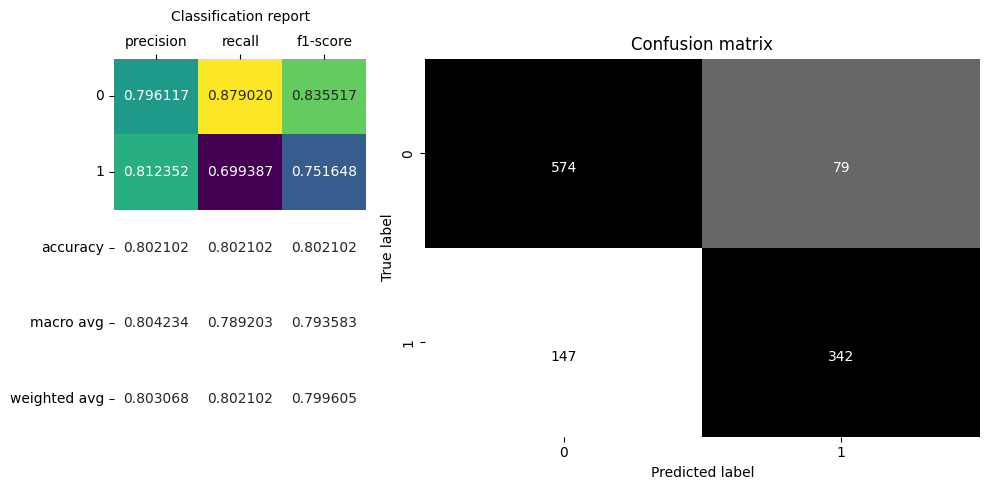

In [ ]:
report = EstimatorReport(model_rnn_1, val_ds, y_val, [], [], "RNN-GRU", False, 2, True)
report.display_report()

In [ ]:
results_df = add_to_results("RNN-GRU", acc, results_df)

## Universal sentence encoder  <a class="anchor" id="use"></a>

The purpose of the Universal Sentence Encoder (USE) is to generate fixed-length numerical representations, or embeddings, for sentences or short text inputs. It is a pre-trained model developed by Google Research that aims to capture the semantic meaning and contextual information of textual inputs.
The embedded text generated by the USE will be used for subsequent training of DNN model.

In [ ]:
encoder_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed_module = hub.load(encoder_url)

In [ ]:
X_train_embeddings = embed_module(X_train)
X_val_embeddings = embed_module(X_val)
X_test_embeddings = embed_module(X_test)
X_train_embeddings.shape, X_val_embeddings.shape, X_test.shape

(TensorShape([6471, 512]), TensorShape([1142, 512]), (3263,))

Create dataset from embeddings.

In [ ]:
train_embeddings_ds = tf.data.Dataset.from_tensor_slices((X_train_embeddings, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_embeddings_ds = tf.data.Dataset.from_tensor_slices((X_val_embeddings, y_val)).batch(32)
test_embeddings_ds = tf.data.Dataset.from_tensor_slices(X_test_embeddings).batch(32)
train_embeddings_ds.element_spec, val_embeddings_ds.element_spec, test_embeddings_ds.element_spec

((TensorSpec(shape=(None, 512), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 512), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, 512), dtype=tf.float32, name=None))

In [ ]:
model_sent_enc = tf.keras.Sequential([
    Dropout(0.3),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
%%time
_, acc = fit_and_evaluate(
    model_sent_enc,
    train_embeddings_ds,
    val_embeddings_ds,
    learning_rate=0.01
)

Epoch 1/50
203/203 [==============================] - 2s 5ms/step - loss: 0.4639 - accuracy: 0.7889 - val_loss: 0.4112 - val_accuracy: 0.8240 - lr: 0.0100
Epoch 2/50
203/203 [==============================] - 1s 3ms/step - loss: 0.4132 - accuracy: 0.8184 - val_loss: 0.4138 - val_accuracy: 0.8222 - lr: 0.0100
Epoch 3/50
203/203 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8240
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
203/203 [==============================] - 1s 4ms/step - loss: 0.3975 - accuracy: 0.8240 - val_loss: 0.4045 - val_accuracy: 0.8222 - lr: 0.0100
Epoch 4/50
203/203 [==============================] - 1s 4ms/step - loss: 0.3721 - accuracy: 0.8405 - val_loss: 0.3977 - val_accuracy: 0.8380 - lr: 0.0030
Epoch 5/50
203/203 [==============================] - 1s 4ms/step - loss: 0.3694 - accuracy: 0.8384 - val_loss: 0.3967 - val_accuracy: 0.8319 - lr: 0.0030
Epoch 6/50
187/203 [==========================>...] - ETA: 0s - 

36/36 [==============================] - 0s 2ms/step


### <span style="color: black;">Evaluation on the Validation Set (estimator: Univ sent encoder)</span>

Accuracy: 83.8004%

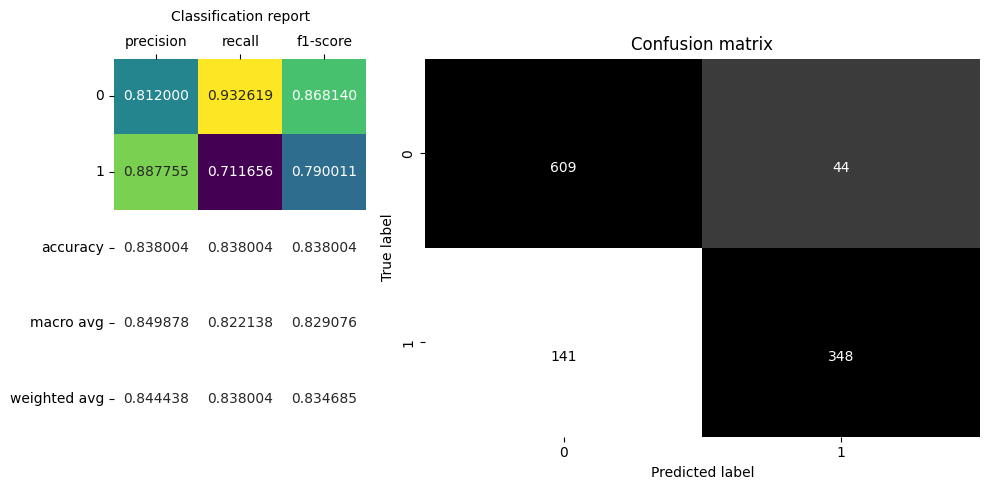

In [ ]:
EstimatorReport(model_sent_enc, val_embeddings_ds, y_val, [], [], "Univ sent encoder", False, 2, True).display_report()

In [ ]:
results_df = add_to_results("USE", acc, results_df)

In [ ]:
gc.collect()

6637

## RoBERTa <a class="anchor" id="roberta"></a>

Let's create, train and assess more specific models from Transformers family. Start from RoBERTa (Robustly Optimized BERT approach) model. See more in <a href="https://huggingface.co/docs/transformers/model_doc/roberta">model_doc</a>

In [ ]:
def get_tokenizer_max_len(data):
    token_lens = []
    for txt in data:
        tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    max_length=np.max(token_lens)
    return max_length

In [ ]:
tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

I tried different values of params num_hidden_layers, num_attention_heads but with no improvements.

In [ ]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model_roberta.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Get max sequences length.

In [ ]:
MAX_LEN = get_tokenizer_max_len(X_full)
MAX_LEN

70

Create additional functions and create tokenized datasets. Funtion get_tokenized_ds will be used for other models too.

In [ ]:
def get_tokenized_ds(X_data, y_data, tokenizer, batch_size=32, prefetch=True):
    X_data_tokenized = tokenizer(X_data)
    X_data_tokenized_ds = tf.data.Dataset.from_tensor_slices(X_data_tokenized)
    if len(y_data) > 0:
        y_data_ds = tf.data.Dataset.from_tensor_slices(y_data)
        data_ds = tf.data.Dataset.zip((X_data_tokenized_ds, y_data_ds))
    else:
        data_ds = X_data_tokenized_ds
    if batch_size>0:
        data_ds = data_ds.batch(batch_size)
    if prefetch:
        data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

In [ ]:
def tokenizer_roberta_wrapper(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

Check how tokenizer works, and its output structure.

In [ ]:
encoded_item_example = tokenizer_roberta.encode_plus(
            X_train[0],
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_attention_mask=True,
            padding='max_length',
            truncation=True,
        )
encoded_item_example

{'input_ids': [0, 33877, 4845, 14, 1011, 21, 23523, 14045, 12846, 849, 17858, 863, 4113, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Create filled with zeros array for test dataset as fake labels. Model's predict method using this dataset without labels isn't working correctly. Also can be used separate arrays for input_ids and attention_mask, but for sequencing I use tf.data.Dataset.

In [ ]:
y_test_fake = np.zeros(len(X_test))
y_test_fake.shape

(3263,)

In [ ]:
train_roberta_ds = get_tokenized_ds(X_train, y_train, tokenizer_roberta_wrapper)
val_roberta_ds = get_tokenized_ds(X_val, y_val, tokenizer_roberta_wrapper)
test_roberta_ds = get_tokenized_ds(X_test, y_test_fake, tokenizer_roberta_wrapper, prefetch=False)
train_roberta_ds.element_spec, val_roberta_ds.element_spec, test_roberta_ds.element_spec

(((TensorSpec(shape=(None, 70), dtype=tf.int64, name=None),
   TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ((TensorSpec(shape=(None, 70), dtype=tf.int64, name=None),
   TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ((TensorSpec(shape=(None, 70), dtype=tf.int64, name=None),
   TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)),
  TensorSpec(shape=(None,), dtype=tf.float64, name=None)))

In [ ]:
%%time
_, acc = fit_and_evaluate(
    model_roberta,
    train_roberta_ds,
    val_roberta_ds,
    learning_rate=1e-5,
    epochs=10,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    es_patience=3
)

Epoch 1/10
203/203 [==============================] - 171s 579ms/step - loss: 0.4760 - accuracy: 0.7691 - val_loss: 0.3967 - val_accuracy: 0.8292 - lr: 1.0000e-05
Epoch 2/10
203/203 [==============================] - 94s 464ms/step - loss: 0.3508 - accuracy: 0.8586 - val_loss: 0.3858 - val_accuracy: 0.8424 - lr: 1.0000e-05
Epoch 3/10
203/203 [==============================] - 92s 455ms/step - loss: 0.2978 - accuracy: 0.8838 - val_loss: 0.3901 - val_accuracy: 0.8371 - lr: 1.0000e-05
Epoch 4/10
203/203 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.9110
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
203/203 [==============================] - 92s 455ms/step - loss: 0.2407 - accuracy: 0.9110 - val_loss: 0.4325 - val_accuracy: 0.8275 - lr: 1.0000e-05
Epoch 5/10
36/36 [==============================] - 5s 148ms/step - loss: 0.3858 - accuracy: 0.8424
CPU times: user 6min 4s, sys: 47.7 s, total: 6min 52s
Wall time: 10min


In [ ]:
import matplotlib.pyplot as plt

# Import thư viện để tính thời gian
import time

# Định nghĩa hàm huấn luyện và đánh giá mô hình
def fit_and_evaluate(model, train_dataset, val_dataset, learning_rate, epochs, loss, es_patience):
    start_time = time.time()

    # Compile mô hình
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss,
                  metrics=['accuracy'])

    # Sử dụng EarlyStopping để dừng huấn luyện sớm nếu không cải thiện
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=es_patience,
                                                     restore_best_weights=True)

    # Huấn luyện mô hình
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=val_dataset,
                        callbacks=[early_stopping],
                        verbose=1)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # In biểu đồ loss và accuracy
    plt.figure(figsize=(12, 4))

    # Biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm fit_and_evaluate và hiển thị biểu đồ
fit_and_evaluate(model_roberta, train_roberta_ds, val_roberta_ds, learning_rate=1e-5, epochs=10, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), es_patience=3)


In [ ]:
EstimatorReport(model_roberta, val_roberta_ds, y_val, [], [], "RoBERTa", True, 2).display_report()

 6/36 [====>.........................] - ETA: 4s

In [ ]:
results_df = add_to_results("RoBERTa", acc, results_df)

In [ ]:
gc.collect()

6697

## Twitter-roBERTa <a class="anchor" id="twitterroberta"></a>

Create another BERT variant: Twitter-roBERTa. See: <a href="https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment">model_doc</a>

In [ ]:
def tokenizer_twitter_roberta_wrapper(data):
    tokenized_data = tokenizer_twitter_roberta(data.tolist(), return_tensors="np", padding=True)
    return dict(tokenized_data)

In [ ]:
tokenizer_twitter_roberta = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base", do_lower_case=True)

In [ ]:
model_twitter_roberta = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base", num_labels=2)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_twitter_roberta.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_twitter_roberta_ds = get_tokenized_ds(X_train, y_train, tokenizer_twitter_roberta_wrapper, prefetch=False)
val_twitter_roberta_ds = get_tokenized_ds(X_val, y_val, tokenizer_twitter_roberta_wrapper, prefetch=False)
test_twitter_roberta_ds = get_tokenized_ds(X_test, y_test_fake, tokenizer_twitter_roberta_wrapper, prefetch=False)
train_twitter_roberta_ds.element_spec, val_twitter_roberta_ds.element_spec, test_twitter_roberta_ds.element_spec

(({'input_ids': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 67), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 67), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 68), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 68), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.float64, name=None)))

In [ ]:
%%time
_, acc = fit_and_evaluate(
    model_twitter_roberta,
    train_twitter_roberta_ds,
    val_twitter_roberta_ds,
    learning_rate=1e-5,
    epochs=10,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    es_patience=3
)

Epoch 1/10
203/203 [==============================] - 148s 503ms/step - loss: 0.4756 - accuracy: 0.7721 - val_loss: 0.3840 - val_accuracy: 0.8345 - lr: 1.0000e-05
Epoch 2/10
203/203 [==============================] - 93s 457ms/step - loss: 0.3415 - accuracy: 0.8614 - val_loss: 0.3799 - val_accuracy: 0.8424 - lr: 1.0000e-05
Epoch 3/10
203/203 [==============================] - 92s 455ms/step - loss: 0.2914 - accuracy: 0.8901 - val_loss: 0.4041 - val_accuracy: 0.8327 - lr: 1.0000e-05
Epoch 4/10
203/203 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9150
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
203/203 [==============================] - 92s 455ms/step - loss: 0.2333 - accuracy: 0.9150 - val_loss: 0.4791 - val_accuracy: 0.8240 - lr: 1.0000e-05
Epoch 5/10
36/36 [==============================] - 5s 150ms/step - loss: 0.3799 - accuracy: 0.8424
CPU times: user 6min 2s, sys: 49.4 s, total: 6min 51s
Wall time: 9min 7s


36/36 [==============================] - 5s 145ms/step


### <span style="color: black;">Evaluation on the Validation Set (estimator: Twitter-roBERTa)</span>

Accuracy: 84.2382%

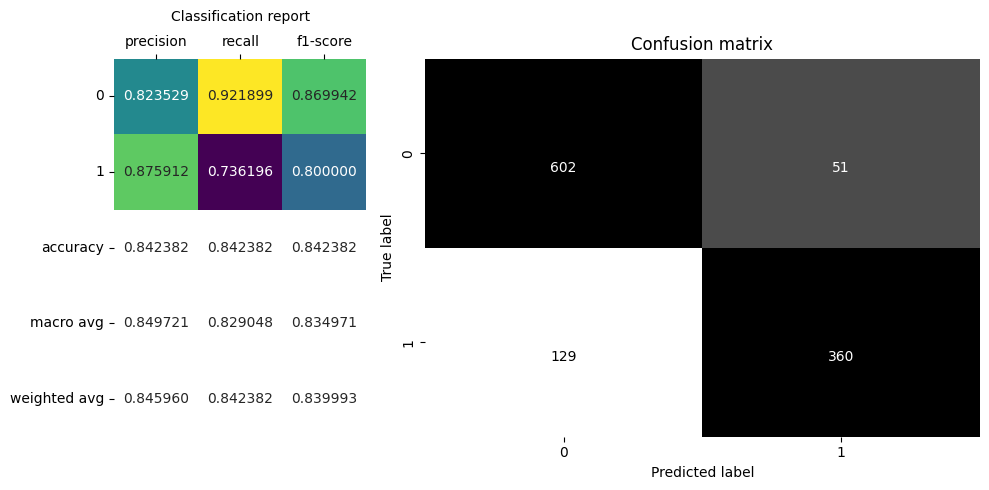

In [ ]:
EstimatorReport(model_twitter_roberta, val_twitter_roberta_ds, y_val, [], [], "Twitter-roBERTa", True, 2).display_report()

In [ ]:
results_df = add_to_results("Twitter-roBERTa", acc, results_df)

In [ ]:
gc.collect()

6716

## Bert <a class="anchor" id="bert"></a>

BERT stands for Bidirectional Encoder Representations from Transformers. It is a transformer-based model for natural language processing (NLP) tasks. It was introduced by researchers at Google in 2018 and has since become a widely adopted and influential model in the field of NLP. See: <a href="https://huggingface.co/docs/transformers/model_doc/bert">model_doc</a>

In [ ]:
def tokenizer_bert_wrapper(data):
    tokenized_data = tokenizer_bert(data.tolist(), return_tensors="np", padding=True)
    return dict(tokenized_data)

In [ ]:
model_bert = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_114 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

In [ ]:
train_bert_ds = get_tokenized_ds(X_train, y_train, tokenizer_bert_wrapper, prefetch=False)
val_bert_ds = get_tokenized_ds(X_val, y_val, tokenizer_bert_wrapper, prefetch=False)
test_bert_ds = get_tokenized_ds(X_test, y_test_fake, tokenizer_bert_wrapper, prefetch=False)
train_bert_ds.element_spec, val_bert_ds.element_spec, test_bert_ds.element_spec

(({'input_ids': TensorSpec(shape=(None, 84), dtype=tf.int64, name=None),
   'token_type_ids': TensorSpec(shape=(None, 84), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 84), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 73), dtype=tf.int64, name=None),
   'token_type_ids': TensorSpec(shape=(None, 73), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 73), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 63), dtype=tf.int64, name=None),
   'token_type_ids': TensorSpec(shape=(None, 63), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 63), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.float64, name=None)))

In [ ]:
%%time
_, acc = fit_and_evaluate(
    model_bert,
    train_bert_ds,
    val_bert_ds,
    learning_rate=5e-6,
    epochs=10,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    es_patience=3
)

Epoch 1/10
203/203 [==============================] - 165s 570ms/step - loss: 0.5519 - accuracy: 0.7110 - val_loss: 0.4145 - val_accuracy: 0.8196 - lr: 5.0000e-06
Epoch 2/10
203/203 [==============================] - 108s 531ms/step - loss: 0.3860 - accuracy: 0.8430 - val_loss: 0.3975 - val_accuracy: 0.8240 - lr: 5.0000e-06
Epoch 3/10
203/203 [==============================] - 108s 530ms/step - loss: 0.3293 - accuracy: 0.8761 - val_loss: 0.4094 - val_accuracy: 0.8257 - lr: 5.0000e-06
Epoch 4/10
203/203 [==============================] - 108s 530ms/step - loss: 0.2838 - accuracy: 0.8934 - val_loss: 0.4385 - val_accuracy: 0.8301 - lr: 5.0000e-06
Epoch 5/10
203/203 [==============================] - 107s 528ms/step - loss: 0.2444 - accuracy: 0.9147 - val_loss: 0.4778 - val_accuracy: 0.8284 - lr: 5.0000e-06
Epoch 6/10
203/203 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9340
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-06.
203/203 [===

36/36 [==============================] - 6s 158ms/step


### <span style="color: black;">Evaluation on the Validation Set (estimator: Bert)</span>

Accuracy: 83.0123%

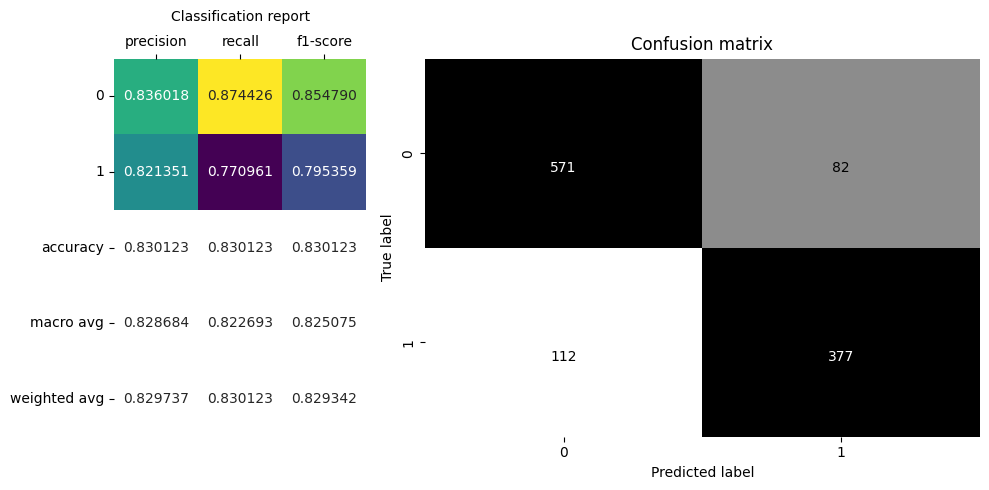

In [ ]:
EstimatorReport(model_bert, val_bert_ds, y_val, [], [], "Bert", True, 2).display_report()

In [ ]:
results_df = add_to_results("Bert", acc, results_df)

In [ ]:
gc.collect()

6684

## Distilbert <a class="anchor" id="distilbert"></a>

Create DistilBERT model. It is smaller and faster version of BERT. See: <a href="https://huggingface.co/docs/transformers/model_doc/distilbert">model_doc</a>

In [ ]:
def tokenizer_distilbert_wrapper(data):
    return dict(tokenizer_distilbert(data.tolist(), return_tensors="np", padding=True))

In [ ]:
tokenizer_distilbert = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

In [ ]:
model_distilbert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model_distilbert.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_134 (Dropout)       multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_distilbert_ds = get_tokenized_ds(X_train, y_train, tokenizer_distilbert_wrapper)
val_distilbert_ds = get_tokenized_ds(X_val, y_val, tokenizer_distilbert_wrapper)
test_distilbert_ds = get_tokenized_ds(X_test, y_test_fake, tokenizer_distilbert_wrapper, prefetch=False)
train_distilbert_ds.element_spec, val_distilbert_ds.element_spec, test_distilbert_ds.element_spec

(({'input_ids': TensorSpec(shape=(None, 82), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 82), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 69), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 69), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 ({'input_ids': TensorSpec(shape=(None, 59), dtype=tf.int64, name=None),
   'attention_mask': TensorSpec(shape=(None, 59), dtype=tf.int64, name=None)},
  TensorSpec(shape=(None,), dtype=tf.float64, name=None)))

In [ ]:
%%time
_, acc = fit_and_evaluate(
    model_distilbert,
    train_distilbert_ds,
    val_distilbert_ds,
    learning_rate=5e-6,
    epochs=15,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    es_patience=3
)

Epoch 1/15
203/203 [==============================] - 86s 309ms/step - loss: 0.5306 - accuracy: 0.7518 - val_loss: 0.4029 - val_accuracy: 0.8345 - lr: 5.0000e-06
Epoch 2/15
203/203 [==============================] - 54s 264ms/step - loss: 0.3871 - accuracy: 0.8419 - val_loss: 0.3921 - val_accuracy: 0.8327 - lr: 5.0000e-06
Epoch 3/15
203/203 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8649
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-06.
203/203 [==============================] - 53s 263ms/step - loss: 0.3431 - accuracy: 0.8649 - val_loss: 0.4046 - val_accuracy: 0.8310 - lr: 5.0000e-06
Epoch 4/15
203/203 [==============================] - 54s 265ms/step - loss: 0.3120 - accuracy: 0.8822 - val_loss: 0.3991 - val_accuracy: 0.8380 - lr: 1.5000e-06
Epoch 5/15
203/203 [==============================] - 54s 266ms/step - loss: 0.2995 - accuracy: 0.8890 - val_loss: 0.4019 - val_accuracy: 0.8406 - lr: 1.5000e-06
Epoch 6/15
203/203 [========

36/36 [==============================] - 3s 78ms/step


### <span style="color: black;">Evaluation on the Validation Set (estimator: Distilbert)</span>

Accuracy: 84.5009%

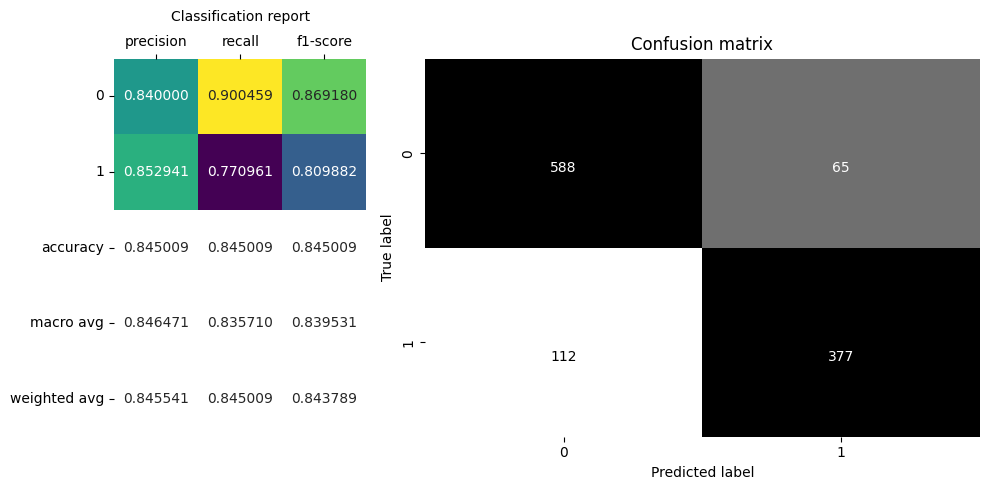

In [ ]:
EstimatorReport(model_distilbert, val_distilbert_ds, y_val, [], [], "Distilbert", True, 2).display_report()

In [ ]:
results_df = add_to_results("Distilbert", acc, results_df)

## Ensembling <a class="anchor" id="ensembling"></a>

In [ ]:
display(results_df
        .sort_values(by='accuracy', ascending=False)
        .reset_index(drop=True)
        .style
        .background_gradient(cmap='viridis')
        .set_properties(**{'text-align': 'left'})
       )

,model,accuracy
0,Distilbert,0.845009
1,RoBERTa,0.842382
2,Twitter-roBERTa,0.842382
3,USE,0.838004
4,Bert,0.830123
5,RNN-GRU,0.802102


Create a stacked average predictions from best models more precisely using RoBERTa, Twitter-roBERTa and Bert models (I also tried other combinations but these are shows better results).

In [ ]:
def get_stacked_predictions(models, datasets):
    predicted_logits = []
    for model, ds in zip(models, datasets):
        y_predictions = model.predict(ds)
        predicted_logits.append(y_predictions.logits)
    predicted_probas = [softmax(logits, axis=-1) for logits in predicted_logits]
    predicted_probas_class_1 = [probas[:, 1] for probas in predicted_probas]
    stacked_probas_class_1 = np.stack(predicted_probas_class_1)
    stacked_probas_class_1_avg = stacked_probas_class_1.mean(axis=0)
    stacked_predictions = [1 if each > 0.5 else 0 for each in stacked_probas_class_1_avg]
    return stacked_predictions

In [ ]:
best_models = [model_roberta, model_twitter_roberta, model_bert]
test_datasets = [test_roberta_ds, test_twitter_roberta_ds, test_bert_ds]
final_predictions = get_stacked_predictions(best_models, test_datasets)

# Submission <a class="anchor" id="submission"></a>

In [ ]:
submission_df.loc[:, 'target'] = final_predictions
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=True)

# Conclusion <a class="anchor" id="conclusion"></a>

BERT models showed better performance than simple RNN models. By training multiple BERT family models using fine-tuning and ensembling, was achieved good performance for test dataset.